# Is the cost-loss ratio still a suitable decsription of alpha? Are the average costs and losses equal to alpha?

## Logistic damages at 90th percentile threshold, risk neutral, 14-day moving average reference

In [12]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [13]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
from fontTools.cffLib import encodeNumber
from matplotlib import pyplot as plt
import pickle
import bz2

from scipy.special import xlogy
from xarray.util.generate_aggregations import skipna

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *
from ruv.helpers import *

In [14]:
awrc = '405219'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 6
verbose = False

In [15]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'], data['fcst']
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 497)


# Define decision context

In [16]:
ref = clim_ens

alphas = np.array([0.1, 0.25, 0.5, 0.75, 0.9])

decision_definition = {
    'economic_model_params': alphas,
    'damage_function': [logistic_zero, {'A': 1, 'k': 0.5, 'threshold': np.nanquantile(obs, 0.75)}],
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_rule': 'optimise_over_forecast_distribution',
    #'decision_rule': 'critical_probability_threshold_equals_par',
    #'decision_rule': 'critical_probability_threshold_fixed',     # TODO: keeps returning almost flat value diagrams
    #'decision_rule': 'critical_probability_threshold_max_value',
    'critical_probability_threshold': 0.25,
    'utility_function': [cara, {'A': 0}],
    'event_freq_ref': True
}

# Defining these outside the decision_definition dictionary allows 
# us to vary them as experimental variables later
decision_types = ['Binary', 'Multicategorical', 'Continuous']

binary_thresholds = np.insert(np.nanquantile(obs, [0.75]), 0, 0)
multicategorical_thresholds = np.insert(np.nanquantile(obs, np.array([0.5, 0.75, 0.95])), 0, 0)

# Calculate RUV

In [17]:
results = xr.DataArray(np.nan, dims=['alphas', 'decision_types'], coords={'alphas': alphas, 'decision_types': decision_types})

detailed_results = {}
    
for decision_type in decision_types:
    print(decision_type)

    if decision_type == 'Binary':
        decision_definition['decision_thresholds'] = binary_thresholds

    elif decision_type == 'Multicategorical':
        decision_definition['decision_thresholds'] = multicategorical_thresholds

    elif decision_type == 'Continuous':
        decision_definition['decision_thresholds'] = None

    result = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes, verbose)
    results.loc[:, decision_type] = result['ruv']
    detailed_results[decision_type] = result

Binary
Multicategorical
Continuous


In [18]:
results

<xarray.DataArray (alphas: 5, decision_types: 3)> Size: 120B
array([[0.77899276, 0.76649834, 0.80605101],
       [0.89355855, 0.82221581, 0.8158899 ],
       [0.81761006, 0.86880928, 0.78576268],
       [0.6981132 , 0.77771561, 0.7014065 ],
       [0.63421556, 0.72421868, 0.60169878]])
Coordinates:
  * alphas          (alphas) float64 40B 0.1 0.25 0.5 0.75 0.9
  * decision_types  (decision_types) <U16 192B 'Binary' ... 'Continuous'

# Plot RUV

<Axes: title={'center': 'Value diagram'}, xlabel='Alpha', ylabel='RUV'>

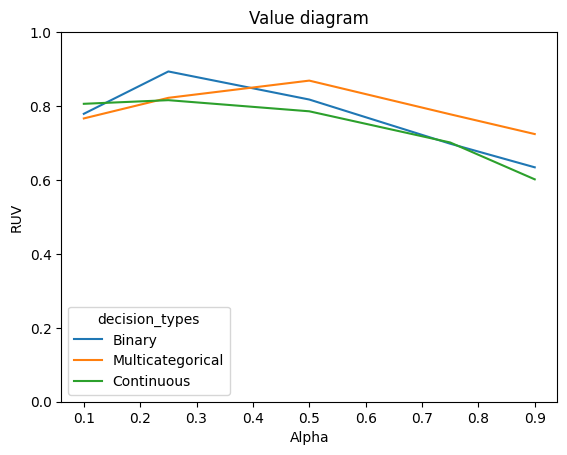

In [19]:
df = results.to_pandas()
df.plot(ylim=(0,1), kind='line', title='Value diagram', xlabel='Alpha', ylabel='RUV')

In [20]:
detailed_results['Multicategorical'].keys()

dict_keys(['ruv', 'avg_fcst_ex_post', 'avg_ref_ex_post', 'avg_obs_ex_post', 'fcst_spends', 'ref_spends', 'obs_spends', 'fcst_ex_ante', 'ref_ex_ante', 'obs_ex_ante', 'fcst_ex_post', 'ref_ex_post', 'obs_ex_post', 'fcst_expected_damages', 'ref_expected_damages', 'obs_damages'])

In [21]:
RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

for decision_type in decision_types:
    for data_type in ['fcst']:
        costs = detailed_results[decision_type]['%s_spends' % data_type]
        losses = detailed_results[decision_type]['obs_damages']        
        
        for i, alpha in enumerate(alphas):       
            costs_losses = pd.DataFrame({'costs': costs[i, :], 'losses': losses[i, :]})
                               
            # avg_costs_losses = costs_losses.mean(skipna=True)     
            # cost_loss_calc = avg_costs_losses['costs'] / avg_costs_losses['losses'] if avg_costs_losses['losses'] != 0 else -99            

            cost_loss_ratios = costs_losses['costs'] / costs_losses['losses']
            cost_loss_ratios.replace([np.inf, -np.inf], np.nan, inplace=True)
            cost_loss_calc = cost_loss_ratios.mean(skipna=True)
            
            is_close = np.isclose(alpha, cost_loss_calc, 1e-1)
            closeness = f'{GREEN}[is_close=%s]{RESET}' % is_close if is_close else f'{RED}[is_close=%s]{RESET}' % is_close
            print(f'%s %s-%s alpha=%.2f cost_loss_ratio=%.2f' % (closeness, decision_type, data_type, alpha, cost_loss_calc))  

[is_close=True] Binary-fcst alpha=0.10 cost_loss_ratio=0.10
[is_close=True] Binary-fcst alpha=0.25 cost_loss_ratio=0.24
[is_close=False] Binary-fcst alpha=0.50 cost_loss_ratio=0.44
[is_close=False] Binary-fcst alpha=0.75 cost_loss_ratio=0.56
[is_close=False] Binary-fcst alpha=0.90 cost_loss_ratio=0.60
[is_close=True] Multicategorical-fcst alpha=0.10 cost_loss_ratio=0.11
[is_close=True] Multicategorical-fcst alpha=0.25 cost_loss_ratio=0.26
[is_close=True] Multicategorical-fcst alpha=0.50 cost_loss_ratio=0.48
[is_close=False] Multicategorical-fcst alpha=0.75 cost_loss_ratio=0.65
[is_close=False] Multicategorical-fcst alpha=0.90 cost_loss_ratio=0.71
[is_close=True] Continuous-fcst alpha=0.10 cost_loss_ratio=0.11
[is_close=True] Continuous-fcst alpha=0.25 cost_loss_ratio=0.26
[is_close=True] Continuous-fcst alpha=0.50 cost_loss_ratio=0.50
[is_close=True] Continuous-fcst alpha=0.75 cost_loss_ratio=0.72
[is_close=True] Continuous-fcst alpha=0.90 cost_loss_ratio=0.85


# analysis
- Cost-loss ratio calculated using the expected damages as the losses (ex ante forecast likelihoods x damages for each threshold) 
- Only matches alpha unless when using deterministic data (ie. decision threshold which converts ensemble to deterministic)
- So, this method of expected damages is not a suitable description of alpha
- Could try a different way to estimate losses (actual ex post loss suffered)
- Ref should be left ensemble and not converted to deterministic, if someone wants to assess with a deterministic reference they should have to explicitly do this